# Collapse trees to shared clades for comparison

The script prunes and collapses two or more trees to a shared set of clades. Note that the goals are "**clades**" rather than "**taxa**". A shared clade is defined as a clade present in all trees, with the same set of descendants. The resulting trees can then be used for back-to-back comparison (e.g., using [Dendroscope](http://dendroscope.org/)'s tanglegram function).

Finding a shared set of clades is not trivial. In computer science it is a special form of the [covering problem](https://en.wikipedia.org/wiki/Covering_problems). While exploring the optimal solution is beyond the scope of this study, I designed and implemented a working heuristic to achieve the goal.

In [112]:
import scipy as sp
import matplotlib.pyplot as plt
from skbio import TreeNode

Number of clades to retain.

In [113]:
clades_to_retain = 50

Minimum number of descendants for a retained clade.

In [114]:
clade_min_size = 50

In [115]:
trees = [
    TreeNode.read('astral.cons.nid.e5p68057.nwk'),
    TreeNode.read('concat.cons.nid.b50.nwk')
]

In [116]:
node2taxa = []
for tree in trees:
    n2t = {}
    for node in tree.postorder():
        if node.is_tip():
            n2t[node.name] = [node.name]
        else:
            n2t[node.name] = []
            for child in node.children:
                n2t[node.name].extend(n2t[child.name])
    node2taxa.append(n2t)

In [117]:
for i in range(len(node2taxa)):
    node2taxa[i] = {k: v for k, v in node2taxa[i].items() if len(v) >= clade_min_size}

In [118]:
for i in range(len(node2taxa)):
    for node in node2taxa[i]:
        node2taxa[i][node] = set(node2taxa[i][node])

In [119]:
matches = {}
for node1, taxa1 in node2taxa[0].items():
    for node2, taxa2 in node2taxa[1].items():
        if taxa1 == taxa2:
            matches[','.join((node1, node2))] = taxa1
print('Matching pairs: %d.' % len(matches))

Matching pairs: 273.


In [120]:
sp.special.comb(len(matches), clades_to_retain)

1.764080433286628e+55

Here is my heuristic for the covering problem. It starts at a given size of clade: *k*, and progressively recruits clades from left and right, until the desired number of clades: *n*, is reached.

In [121]:
universe = set().union(*[v for k, v in matches.items()])
total_size = len(universe)
print('Taxa under matching pairs: %d.' % total_size)

Taxa under matching pairs: 10575.


In [122]:
mean_clade_size = round(len(universe) / clades_to_retain)
mean_clade_size

212

In [123]:
def select_clades(start_size):
    res = []
    for match, taxa in sorted(matches.items(), key=lambda x: abs(start_size - len(x[1]))):
        is_unique = True
        for m in res:
            if not taxa.isdisjoint(matches[m]):
                is_unique = False
                break
        if is_unique is True:
            res.append(match)
        if len(res) == clades_to_retain:
            break
    return res

Test multiple starting sizes.

In [124]:
x, y, z = [], [], []
selections = []
start_size = mean_clade_size
while True:
    selected_matches = select_clades(start_size)
    if len(selected_matches) < clades_to_retain:
        break
    selections.append(selected_matches)
    covered = set().union(*[matches[x] for x in selected_matches])
    cv = sp.stats.variation([len(matches[x]) for x in selected_matches])
    x.append(start_size)
    y.append(len(covered) / total_size)
    z.append(cv)
    print('Starting at %d, covering %d taxa, CV = %.3f' % (start_size, len(covered), cv))
    start_size += 1

Starting at 212, covering 6754 taxa, CV = 0.481
Starting at 213, covering 6754 taxa, CV = 0.481
Starting at 214, covering 6754 taxa, CV = 0.481
Starting at 215, covering 6754 taxa, CV = 0.481
Starting at 216, covering 6754 taxa, CV = 0.481
Starting at 217, covering 6754 taxa, CV = 0.481
Starting at 218, covering 6754 taxa, CV = 0.481
Starting at 219, covering 6754 taxa, CV = 0.481
Starting at 220, covering 6754 taxa, CV = 0.481
Starting at 221, covering 6754 taxa, CV = 0.481
Starting at 222, covering 6754 taxa, CV = 0.481
Starting at 223, covering 6808 taxa, CV = 0.487
Starting at 224, covering 6808 taxa, CV = 0.487
Starting at 225, covering 6808 taxa, CV = 0.487
Starting at 226, covering 6808 taxa, CV = 0.487
Starting at 227, covering 6808 taxa, CV = 0.487
Starting at 228, covering 6904 taxa, CV = 0.516
Starting at 229, covering 6904 taxa, CV = 0.516
Starting at 230, covering 6904 taxa, CV = 0.516
Starting at 231, covering 6904 taxa, CV = 0.516
Starting at 232, covering 6904 taxa, CV 

Starting at 389, covering 7817 taxa, CV = 0.692
Starting at 390, covering 7817 taxa, CV = 0.692
Starting at 391, covering 7817 taxa, CV = 0.692
Starting at 392, covering 7817 taxa, CV = 0.692
Starting at 393, covering 7817 taxa, CV = 0.692
Starting at 394, covering 7817 taxa, CV = 0.692
Starting at 395, covering 7869 taxa, CV = 0.718
Starting at 396, covering 7869 taxa, CV = 0.718
Starting at 397, covering 7869 taxa, CV = 0.718
Starting at 398, covering 7869 taxa, CV = 0.718
Starting at 399, covering 7869 taxa, CV = 0.718
Starting at 400, covering 7869 taxa, CV = 0.718
Starting at 401, covering 7983 taxa, CV = 0.757
Starting at 402, covering 7983 taxa, CV = 0.757
Starting at 403, covering 7983 taxa, CV = 0.757
Starting at 404, covering 7983 taxa, CV = 0.757
Starting at 405, covering 7983 taxa, CV = 0.757
Starting at 406, covering 7983 taxa, CV = 0.757
Starting at 407, covering 7983 taxa, CV = 0.757
Starting at 408, covering 7983 taxa, CV = 0.757
Starting at 409, covering 7983 taxa, CV 

Plot them out.

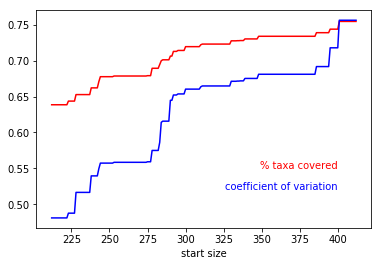

In [134]:
plt.plot(x, y, 'r')
plt.plot(x, z, 'b')
plt.xlabel('start size')
plt.text(400, 0.55, '% taxa covered', color='r', ha='right')
plt.text(400, 0.52, 'coefficient of variation', color='b', ha='right');

The final starting size *k* is manually determined based on the plot.

In [135]:
start_size = 348

In [136]:
selected_matches = select_clades(start_size)
for m in selected_matches:
    print('%s: %d taxa.' % (m, len(matches[m])))

N1081,N646: 350 taxa.
N3758,N8774: 346 taxa.
N2668,N2313: 353 taxa.
N191,N458: 358 taxa.
N1640,N2157: 336 taxa.
N2666,N1610: 367 taxa.
N146,N162: 323 taxa.
N5329,N3630: 315 taxa.
N6294,N6394: 315 taxa.
N4527,N1716: 300 taxa.
N4526,N2077: 291 taxa.
N1838,N2733: 252 taxa.
N4162,N2076: 244 taxa.
N4999,N4055: 199 taxa.
N207,N90: 197 taxa.
N3529,N4053: 197 taxa.
N4218,N3629: 184 taxa.
N250,N428: 156 taxa.
N604,N531: 149 taxa.
N4008,N1609: 131 taxa.
N3029,N1363: 129 taxa.
N3855,N2903: 116 taxa.
N4256,N4934: 109 taxa.
N2699,N3445: 108 taxa.
N4628,N4938: 108 taxa.
N233,N1442: 107 taxa.
N1604,N1435: 106 taxa.
N1636,N2153: 106 taxa.
N117,N21: 105 taxa.
N3757,N8773: 97 taxa.
N2422,N3819: 86 taxa.
N375,N117: 85 taxa.
N1832,N2000: 80 taxa.
N752,N681: 73 taxa.
N4244,N4051: 70 taxa.
N1306,N63: 69 taxa.
N930,N680: 68 taxa.
N1287,N825: 66 taxa.
N1603,N1159: 65 taxa.
N54,N315: 64 taxa.
N923,N354: 64 taxa.
N1602,N522: 63 taxa.
N33,N23: 61 taxa.
N2809,N2483: 60 taxa.
N891,N642: 59 taxa.
N3656,N2312: 57 ta

Write selected clades.

In [137]:
with open('selected_matches.txt', 'w') as f:
    for m in selected_matches:
        f.write('%s\n' % m.replace(',', '\t'))

Export collapsed trees. Each selected clade becomes a tip, with its height equaling the median of its descendants.

In [138]:
def get_clade_height(node):
    return np.median([x.accumulate_to_ancestor(node) for x in node.tips()])

In [139]:
def collapse_clades(tree, clades):
    tcopy = tree.copy()
    clades = set(clades)
    nodes_to_remove = []
    for node in tcopy.non_tips():
        if node.name in clades:
            node.length += get_clade_height(node)
            nodes_to_remove.extend(node.children)
    tcopy.remove_deleted(lambda x: x in nodes_to_remove)
    tcopy = tcopy.shear(clades)
    tcopy.prune()
    return tcopy

In [140]:
for i, tree in enumerate(trees):
    clades = [x.split(',')[i] for x in selected_matches]
    tcopy = collapse_clades(tree, clades)
    tcopy.write('tree%d.nwk' % (i + 1))
    for tip in tcopy.tips():
        tip.name = 'X%d' % (clades.index(tip.name) + 1)
    tcopy.write('tree%d.trans.nwk' % (i + 1))